In [20]:
#imports
import sys
import subprocess 
import scipy.constants as con
import scipy.optimize as opt
import importlib
#import scipy as sp
import numpy as np
from scipy import special
from scipy import integrate
import scipy.linalg as la
from scipy.optimize import root_scalar
from scipy.integrate._ivp import common as jacpack
import time
import matplotlib.pyplot as plt

import pynucastro as pyna
reaclibrary = pyna.ReacLibLibrary()

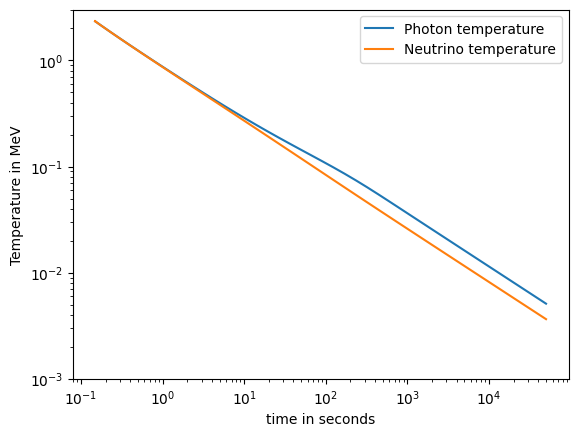

In [21]:
#Background
#Special functions og deres afledte
def L(z):
    return special.kn(2,z)/z

def M(z):
    return (3/4*special.kn(3,z)+1/4*special.kn(1,z))/z

def dMdz(z):
    return -3/z**2*special.kn(3,z) -special.kn(2,z)/z

def N(z):
    return (1/2*special.kn(4,z)+1/2*special.kn(2,z))/z


timeunit =1.519*10**21  #MeV/hbar in unit of 1/second 

n_life=879.6*timeunit   #Neutron lifetime in units of MeV/hbar
Q=1.293                 #neutron proton mass difference in MeV
M_u=931.494102          #atomic mass unit in MeV
SBC=np.pi**2/60         #Stefan-Boltzmann constant in natural units
G=6.709e-45             #gravatational constant in units of c=hbar=MeV=1
#infapprox=1e3           #large number acting as upper limit on itegrals
n_nu=3.046              #number of neutrino families with correction from 
                        #Nollett and Steigman, BBN and the CMB constrain neutrino coupled light WIMPs, 2015

TMeV2T9=11.60451812 #conversion factor from MeV to 10^9K
cm3s=1.167*10**-11  #conversion factor for cm^3/s
gcm3=232012         #conversion factor for g/cm^3
meter=5.068e12      #conversion factor for m
cm=5.068e10         #conversion factor for cm
barn=389.4          #conversion factor for barn
e_mass=0.51099895   #electron mass in MeV


def rho_e(T): #electron/positron density, chemical potential assumed to be 0 so cosh(phi*n)=1
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)/((np.exp(z*x)+1))))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)*M(n*z) for n in range(1,10)])

def drho_e(T): #derivative of rho_e with respect to temperature
    z=e_mass/T
    '''
    func=lambda x: np.real(2/(np.pi**2)*e_mass**4*((x**2*(x**2-1)**0.5)*(z*x*np.exp(z*x))/(T*(np.exp(z*x)+1)**2)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n)*n*z/T*dMdz(n*z) for n in range(1,10)])


def P_e(T): #electron/positron pressure
    z=e_mass/T
    '''
    func=lambda x: 2/(3*np.pi**2)*e_mass**4*((x**4*(x**2+1)**-0.5)/((np.exp(z*(x**2+1)**0.5)+1)))

    result, error = integrate.quad(func, 0, infapprox)#[0]
    return result
    '''
    #Fowler and Hoyle 1964
    #return 4/np.pi**2*T**4*np.sum([(-1)**(n+1)/n**4*special.kn(2,n*z) for n in range(1,10)])
    
    #Kawano
    return 2/np.pi**2*e_mass**4*np.sum([(-1)**(n+1)/(n*z)*L(n*z) for n in range(1,10)])  



def rho_gamma(T):   #photon energy density
    return (np.pi**2)/15*T**4 

def drho_gamma(T):  #derivative
    return 4*(np.pi**2)/15*T**3 

def P_gamma(T):     #photon pressure
    return rho_gamma(T)/3



### Initial conditions ###

T_ini=27/TMeV2T9            #initial temperature in MeV

t_ini=1.226*10**21/T_ini**2 #initial time in hbar/MeV


z_ini=e_mass/T_ini

n_gamma_ini= 1.20206*2/np.pi**2*T_ini**3    #initial number density of photons based on theory
n_gamma_ini= rho_gamma(T_ini)/(2.701*T_ini) #initial number density of photons based mean photon energy

eta=6.1e-10     #CMB baryon-to-photon ratio
eta_ini=eta*(1+(rho_e(T_ini)+P_e(T_ini))/(rho_gamma(T_ini)+P_gamma(T_ini))) #entropi bevarelse


rho_nu_ini=n_nu*7/8*(np.pi**2)/15*T_ini**4 #initial neutrino density

h_ini=M_u/T_ini**3*eta_ini*n_gamma_ini  #initial h



rho_b_ini=M_u*eta_ini*n_gamma_ini    #initial baryon density

rho_tot_ini=rho_e(T_ini)+rho_gamma(T_ini)+rho_nu_ini#+rho_b_ini  #initial total energy density

H_ini=np.sqrt(8*np.pi/3*G*rho_tot_ini)


def rho_nu(T,a): #neutrina energy density
    #return 7/8*np.pi**2/15*T**4
    return rho_nu_ini/a**4

def rho_b(a):
    return rho_b_ini/a**3



#def P_b(T,h):
#    return h*T**4*2/3*

#Phie_ini=np.pi**2/2*con.Avogadro*h_ini/z_ini**3*1/sum([(-1)**(n+1)*n*L(n*z_ini) for n in range(1,20)]) 




### Solving the background ###

def rho_tot(T,a): #total density
    return rho_e(T)+rho_gamma(T)+rho_nu(T,a)#+rho_b(a)

def rho_set(T,a): #total density of non-decoupled components
    return rho_e(T)+rho_gamma(T)#+rho_b(a)

def H(T,a):   #Hubble parameter as given by Friedmann eq, ignoring cosmological constant
    return np.sqrt(8*np.pi/3*G*rho_tot(T,a))

#Derivative from Kavano D.18
def dTdt(t,T,a):
    return -3*H(T,a)/((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))

#Derivative from Kavano D.19
def dhdt(t,T,h,a):
    return -3*h*(H(T,h,a)+dTdt(t,T,h,a)/T)

#Derivative from how H is defined
def dadt(t,T,a):
    return a*H(T,a)


#Derivatives for Jacobian

def dadT(T,a):
    return -((drho_e(T)+drho_gamma(T))/(rho_set(T,a) + P_e(T)+P_gamma(T)))*a/3

def drho_nu(T,a): #neutrina energy density
    return -rho_nu_ini*4/a**5

def drho_b(T,a):
    return -h_ini*T_ini**3*3/a**4

def rho_totdT(T,a): #total density
    return drho_e(T)+drho_gamma(T)+(drho_nu(T,a))#+drho_b(T,a))*dadT(T,a)

def rho_totda(T,a): #total density
    return (drho_e(T)+drho_gamma(T))/dadT(T,a)+drho_nu(T,a)#+drho_b(T,a)



def HdT(T,a):   #Hubble parameter deriv with respect to Temperature
    return 4*np.pi/3*G*rho_totda(T,a)/H(T,a)

def Hda(T,a):   #Hubble parameter deriv with respect to Scale factor
    return 4*np.pi/3*G*rho_totdT(T,a)/H(T,a)

def dadtda(t,T,a):
    return H(T,a)+a*Hda(T,a)


def dadtdT(t,T,a):
    return dadT(T,a)*H(T,a)+a*HdT(T,a)



t_range=[t_ini,5e4*timeunit]            #time range for integration
#t_space=np.linspace(*t_range,1000)      #time range for approximate temperature

#combining derivatives
def dbackground(t,y):   #solve h and T, y[0] = T, y[1] = a
    return [dTdt(t,*y),dadt(t,*y)]



# Solving it
sol = integrate.solve_ivp(dbackground, t_range, [T_ini,1],method='Radau')#,t_eval=t_space)

plt.figure()
# Plot the Temperature
plt.plot(sol.t/timeunit, sol.y[0], label='Photon temperature')

# Test with completely radiation dominated universe
t_space=sol.t
T_approx=np.sqrt(1.226*10**21/t_space)
#T_approx=1/np.sqrt(t_space/timeunit)/10.4*TMeV2T9
plt.plot(t_space/timeunit, T_ini/sol.y[1], label='Neutrino temperature')


#plot the scale factor
#plt.plot(sol.t/timeunit, sol.y[2]/1e3, label='scale factor')

#fix the axis
plt.xlabel('time in seconds')
plt.ylabel('Temperature in MeV')

plt.xscale('log')
plt.yscale('log')

# plt.xlim((0.1, 2e5))
plt.ylim((1e-3,3))

plt.legend()
plt.show()

#plt.figure


n_bparams=2


In [22]:
#import networks

#section for AoT compilation of network
import H2_AoT_net as bbn_H2
import He4_AoT_net as bbn_He4
import AoT_net as bbn_n
import full_AoT_net as bbn_full
networks=[bbn_H2,bbn_He4,bbn_n,bbn_full]
nNucs=[net.nnuc() for net in networks]
nNucs=[0, 0, 10, 26,0]

t_cut=[t_ini,t_ini,t_ini,timeunit]
#times for switching between networks
t_start=[t_ini,t_ini,t_ini,timeunit,1e5*timeunit]


In [23]:
#Setup isotopes based on Alterbbn
Y_labels=['n','p','H2','H3','He3','He4','Li6','Li7','Li8','Be7','Be9','B8','B10','B11','B12','C11','C12','C13','C14','N12','N13','N14','N15','O14','O15','O16']
Alter_Yl=["n","p","H2","H3","He3","He4","Li6","Li7","Be7","Li8","B8","Be9","B10","B11","C11","B12","C12","N12","C13","N13","C14","N14","O14","N15","O15","O16"]

fnNucs=len(Y_labels)

A=np.array([1,1,2,3,3,4,6,7,8,7,9,8,10,11,12,11,12,13,14,12,13,14,15,14,15,16])
Alter_A=[1.,1.,2.,3.,3.,4.,6.,7.,7.,8.,8.,9.,10.,11.,11.,12.,12.,12.,13.,13.,14.,14.,14.,15.,15.,16.]

Z=sorted([0,1,1,1,2,2,3,3,4,3,5,4,5,5,6,5,6,7,6,7,6,7,8,7,8,8.])
Alter_Z=[0.,1.,1.,1.,2.,2.,3.,3.,4.,3.,5.,4.,5.,5.,6.,5.,6.,7.,6.,7.,6.,7.,8.,7.,8.,8.]

def Altersort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(A,Z),L), key=lambda pair: pair[0])])
#print([label for _, label in sorted(zip(A, Y_labels))])

def PNAsort(L):
    if type(L)==list:
        return [x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])]
    else:
        return np.array([x for (a,x) in sorted(zip(zip(Alter_Z,Alter_A),L), key=lambda pair: pair[0])])    


Alterspin=[0.5,0.5,1.,0.5,0.5,0.,1.,1.5,1.5,2.,2.,1.5,3.,1.5,1.5,1.,0.,1.,0.5,0.5,0.,1.,0.,0.5,0.5,0.]
spin=PNAsort(Alterspin)

Alter_mass_excess=[8.071388,7.289028,13.135825,14.949915,14.931325,2.424931,14.0864,14.9078,15.7696,20.9464,22.9212,11.34758,12.05086,8.6680,10.6506,13.3690,0.,17.3382,3.125036,5.3455,3.019916,2.863440,8.006521,0.101439,2.8554,-4.737036]
Alter_mass=[Alter_A[i]*M_u+Alter_mass_excess[i] for i in range(fnNucs)]
m_Nucs = np.array(PNAsort(Alter_mass))
m_n,m_p,m_d,m_t,m_He3,m_He4=m_Nucs[:6]

def rho_bY_cgs(y):
    return sum(m_Nucs[:len(y[n_bparams:])]*y[n_bparams:])*eta_ini*n_gamma_ini/y[1]**3*gcm3


B=[(m_Nucs[1]*Z[i]+m_Nucs[0]*(A[i]-Z[i]))-m_Nucs[i] for i in range(fnNucs)]
g = 1+2*np.array(spin)

print(Alter_Yl)
print(Altersort(Y_labels))

print(Y_labels)
print(PNAsort(Alter_Yl))

['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Be7', 'Li8', 'B8', 'Be9', 'B10', 'B11', 'C11', 'B12', 'C12', 'N12', 'C13', 'N13', 'C14', 'N14', 'O14', 'N15', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']
['n', 'p', 'H2', 'H3', 'He3', 'He4', 'Li6', 'Li7', 'Li8', 'Be7', 'Be9', 'B8', 'B10', 'B11', 'B12', 'C11', 'C12', 'C13', 'C14', 'N12', 'N13', 'N14', 'N15', 'O14', 'O15', 'O16']


In [24]:
#Functions for determining additional abundances for each network

#Initial conditions from thermal equilibrium
def get_Y_thermal(Y,n,T):
    Y_2 = np.zeros(n)
    Y_2[:len(Y)] = Y
    for i in range(len(Y),n):
        tmp = special.zeta(3)**(A[i] - 1)*np.pi**((1 - A[i])/2)*2**((3*A[i] - 5)/2)*A[i]**(5/2)
        Y_2[i] = g[i]*tmp*(T/m_n)**(3*(A[i] - 1)/2)*eta_ini**(A[i] - 1)*Y[1]**Z[i]*Y[0]**(A[i] - Z[i])*np.exp(B[i]/T)/A[i]

    return Y_2

def solve_using_svd(U, s, Vh, b):
    bb = U.T @ b
    y = bb/s
    x = Vh.T @ y
    return x

#Initial conditions from Jacobian
def get_Y_jac(y,i):

    cut_start=max(2,nNucs[i-1])
    AdYdt_cut=lambda Y : Altersort(networks[i].rhs(0, PNAsort(Y) ,rho_bY_cgs(list(y[:n_bparams])+list(PNAsort(Y))), y[0]*TMeV2T9*1e9))
    AdYdt_jac_cut=lambda Y : networks[i].jacobian(0, PNAsort(Y) ,rho_bY_cgs(list(y[:n_bparams])+list(PNAsort(Y))), y[0]*TMeV2T9*1e9)[:, Altersort(range(nNucs[i]))][Altersort(range(nNucs[i]))]
    aY_cut=Altersort(get_Y_thermal(y[n_bparams:][:max(2,nNucs[i-1])],nNucs[i],y[0]))

    Yj = np.array([YY for YY in aY_cut])
    
    
    for cut in range(max(2,nNucs[i-1]), len(Yj) - 2, 1):
        for j in range(10):
            fyj = -AdYdt_cut(Yj)
            jac = AdYdt_jac_cut(Yj)
            if np.any(np.isnan(Yj)) or np.any(np.isinf(Yj)):
                print('Yj:', Yj)
                raise ValueError
            if np.any(np.isnan(fyj)) or np.any(np.isinf(fyj)):
                print('Yj:', Yj)
                print('fyj:', fyj)
                raise ValueError
            # Implement cut:
            fyj = fyj[cut:]
            jac = jac[cut:, cut:]
            
            # Solution using SVD
            U, s, Vh = la.svd(jac)    
            x = solve_using_svd(U, s, Vh, fyj)
            for k in range(1):
                #A · δx = A · (x + δx) − b
                residuals = jac @ x - fyj
                dx = solve_using_svd(U, s, Vh, residuals)
                x -= dx
            Yj[cut:] += x
    return list(y[:n_bparams])+list(PNAsort(Yj))

In [25]:
solY=np.array([[T_ini],[1]])
soltime=np.array([t_ini])

In [26]:
initial_param=get_Y_jac([T_ini,1]+[1/(np.exp(Q/T_ini)+1),1/(np.exp(-Q/T_ini)+1)],2)

i=2
n_params=nNucs[i]+n_bparams

def jacY_anal(t,y):
    return networks[i].jacobian(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit

def jacobian(t,y):

    jac=np.append(np.zeros((nNucs[i],n_bparams)),jacY_anal(t,y),axis=1)
    return np.append(np.zeros((n_bparams,n_params)),jac,axis=0)

def dydt(t,y): 
    result=dbackground(t,y[:n_bparams])+list( networks[i].rhs(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit)             
    return result

jacsolY = integrate.solve_ivp(dydt, [0,t_start[i+1]-t_start[i]], initial_param,method='Radau',atol=1e-80,rtol=1e-6,jac=jacobian)#,t_eval=t_space)

abun=[abun[-1] for abun in jacsolY.y[n_bparams:]]

solY=np.concatenate((np.concatenate((solY,np.multiply(np.ones((len(solY[0]),nNucs[i]-nNucs[i-1])),initial_param[len(solY):]).T)),jacsolY.y),axis=1)

soltime=np.concatenate((soltime,jacsolY.t+t_start[i]))/timeunit


In [27]:
cut_param=get_Y_jac(jacsolY.y[:,-1],3)
i=3
full_n_params=nNucs[i]+n_bparams

def ndfull(t,y): 
    result=dbackground(t,y[:n_bparams])+list( networks[i].rhs(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit)          
    return result

def full_jac(t,y):
    return bbn_full.jacobian(t/timeunit, y[n_bparams:],rho_bY_cgs(y), y[0]*TMeV2T9*1e9)/timeunit

def full_jacobian(t,y):
    jac=np.append(np.zeros((nNucs[3],n_bparams)),full_jac(t,y),axis=1)
    return np.append(np.zeros((n_bparams,full_n_params)),jac,axis=0)

fullsolY = integrate.solve_ivp(ndfull, [0,t_start[i+1]-t_start[i]], cut_param,method='Radau',atol=1e-80,rtol=1e-6,jac=full_jacobian)#,t_eval=t_space)

final_abun=[fabun[-1] for fabun in fullsolY.y[n_bparams:]]

solY=np.concatenate((np.concatenate((solY,np.multiply(np.ones((len(solY[0]),nNucs[i]-nNucs[i-1])),cut_param[len(solY):]).T)),fullsolY.y),axis=1)

soltime=np.concatenate((soltime,fullsolY.t+t_start[i]))/timeunit

In [28]:
#solving with full network





    
    
    


print(fullsolY.message)
print(fullsolY.nfev)
print(fullsolY.njev)
print(fullsolY.nlu)




print([final_abun[0],final_abun[1],2*final_abun[2],3*final_abun[3],3*final_abun[4],4*final_abun[5]])
print('sum: ', sum(np.array(final_abun)*A))

The solver successfully reached the end of the integration interval.
22445
1491
3266
[8.162346269899797e-12, 0.7526617448639068, 3.78117643140536e-05, 1.8346103429834186e-07, 2.322079749031399e-05, 0.24727703659520087]
sum:  1.000000000002113


In [29]:
#Combine the high temperature and and full network solutions
#solY=np.concatenate((np.concatenate((jacsolY.y,np.multiply(np.ones((len(jacsolY.y[0]),nNucs[3]-nNucs[2])),cut_param[n_params:]).T)),fullsolY.y),axis=1)

#soltime=np.concatenate((jacsolY.t+t_ini,fullsolY.t+t_cut[3]))/timeunit

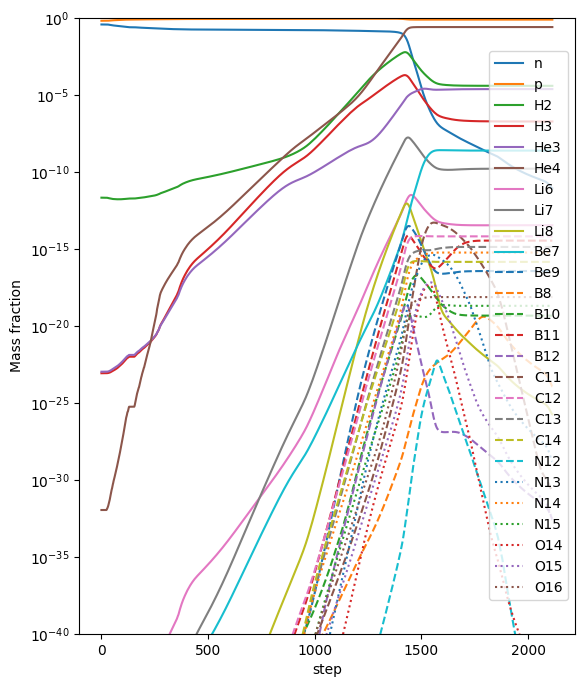

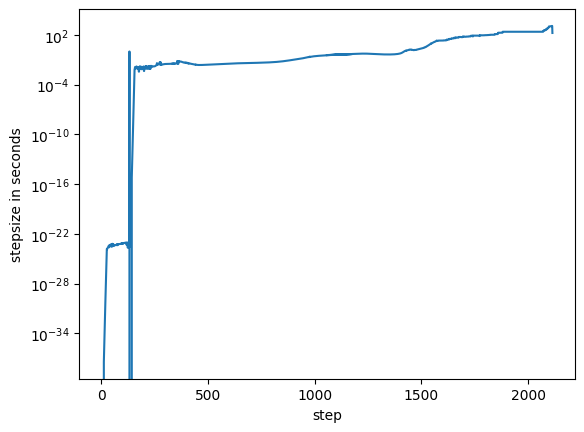

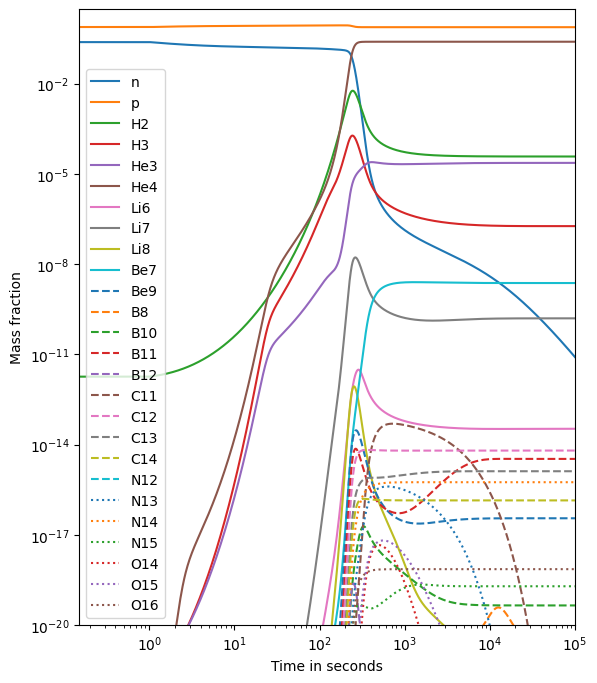

In [30]:
# Plot the results    


plt.figure('abundance',figsize=(6.4, 8))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=3
line=['-']*10+['--']*10+[':']*10

for i in range(fnNucs):
      plt.plot(range(len(soltime)), A[i]*solY[n_bparams+i],line[i], color=colors[i], label=Y_labels[i])

plt.xlabel('step')
plt.ylabel('Mass fraction')
plt.ylim(1e-40,1)
#plt.xlim(0,20)
#plt.xscale('log')
plt.yscale('log')
plt.legend(loc='right')
plt.show()

plt.figure('step size')
plt.plot(range(len(soltime)),[(soltime[i]-soltime[i-1]) for i in range(len(soltime))] )
plt.yscale('log')
plt.xlabel('step')
plt.ylabel('stepsize in seconds')


plt.figure('abundance',figsize=(6.4, 8))
for i in range(fnNucs):
    plt.plot(soltime, A[i]*solY[n_bparams+i],line[i], color=colors[i], label=Y_labels[i])

plt.xlabel('Time in seconds')
plt.ylabel('Mass fraction')
plt.ylim(1e-20,3)
plt.xlim(t_ini/timeunit,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [31]:
#find alterbbn abundance
result = subprocess.run(["/home/hansbdein/Speciale/alterbbn_v2.2/alter_eta.x", str(eta)], capture_output=True)

In [32]:
#compare to Alterbbn abundance
abun=final_abun
print('Observational values')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H ')
print('value:\t 2.450e-01 \t 2.569e-05 \t 1.1e-05 \t 1.6e-10')
print(' +/-  \t 0.030e-01  \t 0.027e-05 \t 0.2e-05 \t 0.3e-10')

print(' ')
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


print(' ')
print('Results from Alterbbn, with theoretical uncertainties:')
for info in result.stdout.decode("utf-8").split('\n')[8:11]:
    print(info)
    #print('lmao')

alterbbn_abun=np.array([float(result.stdout.decode("utf-8").split('\n')[9].split('\t')[i]) for i in range(1,7)])

reorderabun=[4*abun[5],abun[2]/abun[1],(abun[3]+abun[4])/abun[1],(abun[7]+abun[9])/abun[1],(abun[6])/abun[1],(abun[9])/abun[1]]

ratio_Str='ratio:'
for i in range(6):
    ratio_Str+='\t '+ '{:g}'.format(float(result.stdout.decode("utf-8").split('\n')[9].split('\t')[i+1])/reorderabun[i])
print(' ')
print('ratio of this code to ALterbbn results:')
print(ratio_Str)

Observational values
	 Yp  		 H2/H 		 H3/H 		 Li7/H 
value:	 2.450e-01 	 2.569e-05 	 1.1e-05 	 1.6e-10
 +/-  	 0.030e-01  	 0.027e-05 	 0.2e-05 	 0.3e-10
 
Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.473e-01	 2.512e-05	 1.037e-05	 4.768e-10	 7.452e-15	 4.468e-10
 
Results from Alterbbn, with theoretical uncertainties:
	 Yp		 H2/H		 He3/H		 Li7/H		 Li6/H		 Be7/H
value:	 2.473e-01	 2.435e-05	 1.031e-05	 5.466e-10	 1.073e-14	 5.180e-10
 +/- :	 3.209e-04	 9.779e-07	 1.776e-07	 4.427e-11	 1.073e-14	 4.371e-11
 
ratio of this code to ALterbbn results:
ratio:	 1.00009	 0.969397	 0.994683	 1.14645	 1.43989	 1.15931


In [33]:
abun[7]/2.2687415497617955e-11

0.9938299264700781

In [34]:
#Load precise Alterbbn data
data=np.loadtxt('./Alterdata/output.txt',skiprows=2)

'''
#run Alterbbn with chosen integration routine
failsafe=12
subprocess.run(["/home/hansbdein/Speciale/alterbbn_v2.2/no_err_calc.x", str(failsafe)], capture_output=True)
data=np.loadtxt('./output.txt',skiprows=2)
'''


#remove non-time steps
prevtime=0
mask=[]
for timestep in data:
    if timestep[0]>prevtime:
        prevtime=timestep[0]
        mask.append(True)
    else:
        mask.append(False)


data=data[mask,...]

print(data[0,0]/1e3)
#151983983107661.34
#1.519839831076613438e+14
#2.264733810941325e+20

#change Alterbbn data for time and temperature in hbar/GeV to hbar/MeV
data[:,0]*=1e-3
data[:,1]*=1e3
data[:,2]*=1e3
#change order of isotopes to be sorted by Y rather than A
data[:,3:]=PNAsort(data[:,3:].T).T
print(t_ini)

2.2641798198795177e+20
2.264733810941325e+20


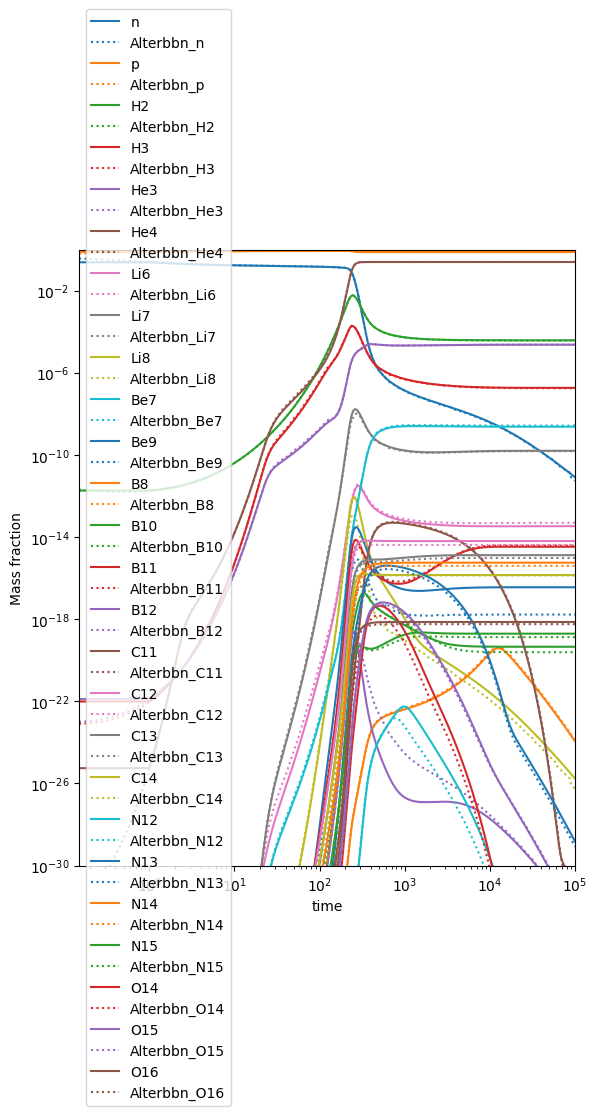

In [35]:
# Plot the results
  
plt.figure('abundance',figsize=(6.4, 8))
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=3

for i in range(fnNucs):
    plt.plot(soltime, A[i]*solY[n_bparams+i],color=colors[i], label=Y_labels[i])
    plt.plot(data[:,0]/timeunit, A[i]*data[:,i+3],':', color=colors[i], label='Alterbbn_'+Y_labels[i])


plt.xlabel('time')
plt.ylabel('Mass fraction')
plt.ylim(1e-30,1)
plt.xlim(t_ini/timeunit ,1e5)
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left')
plt.show()

In [36]:
t_space=[point for point in data[:,0] if point<t_cut[3]]-data[0,0]

alterjacsolY = integrate.solve_ivp(ndall, [0,t_cut[3]-t_ini], initial_param,method='Radau',atol=1e-80,rtol=1e-6,jac=jacobian,t_eval=t_space)

ft_space=[point for point in data[:,0] if point>t_cut[3]]
ft_space-=ft_space[0]
alterfullsolY = integrate.solve_ivp(ndfull, [0,ft_space[-1]], cut_param,method='Radau',atol=1e-80,rtol=1e-6,jac=full_jacobian,t_eval=ft_space)


NameError: name 'ndall' is not defined

In [ ]:
#Combine the high temperature and and full network solutions
altersolY=np.concatenate((np.concatenate((alterjacsolY.y,np.multiply(np.ones((len(alterjacsolY.y[0]),nNucs[3]-nNucs[2])),cut_param[n_params:]).T)),alterfullsolY.y),axis=1)

altersoltime=np.concatenate((alterjacsolY.t+t_ini,alterfullsolY.t+t_cut[3]))/timeunit

NameError: name 'alterjacsolY' is not defined

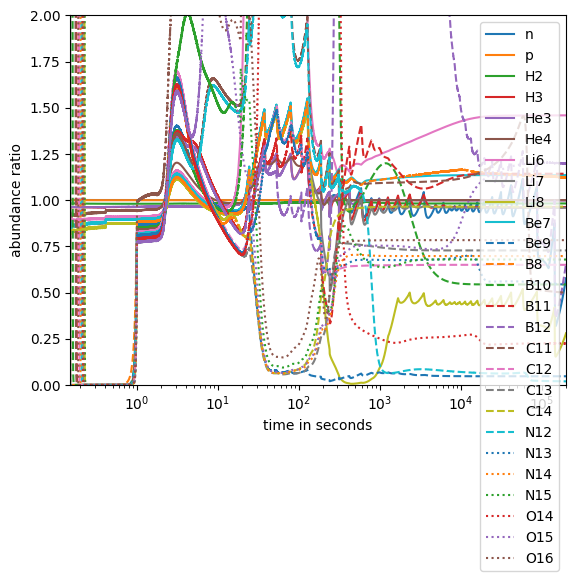

In [ ]:
# Plot the results
plt.figure('abundance')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors*=3
line=['-']*10+['--']*10+[':']*10

for i in range(fnNucs):
    plt.plot(data[:,0]/timeunit, data[:,i+3]/altersolY[n_bparams+i],line[i],color=colors[i], label=Y_labels[i])

plt.xlabel('time in seconds')
plt.ylabel('abundance ratio')

plt.xscale('log')


plt.xlim((data[0,0]/timeunit, 2e5))
plt.ylim(0,2)

plt.legend(loc='upper right')
plt.show()

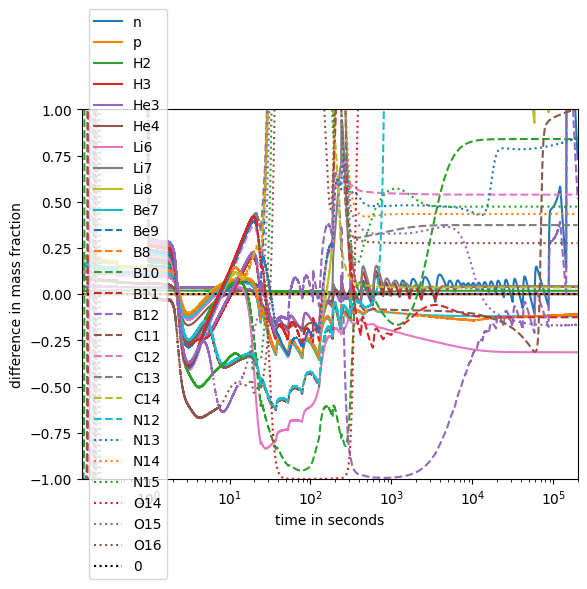

In [ ]:
#plt.plot(data[:,0]/timeunit, (SolAltertime.y[n_bparams+i]-data[:,i+3])/data[:,i+3], label=' (Y - Y_alterbbn)/Y_alterbbn')
#plt.plot(data[:,0]/timeunit, (data[:,0]/timeunit/1e2)**-10*A[5]*data[:,5+3],':', label='Alterbbn_Helium4')
#plt.axhline(0,color='r',linestyle='--',label='0')

for i in range(fnNucs):
    plt.plot(data[:,0]/timeunit, (altersolY[n_bparams+i]-data[:,i+3])/data[:,i+3],line[i],color=colors[i], label=Y_labels[i])

plt.xlabel('time in seconds')
plt.ylabel('difference in mass fraction')

plt.xscale('log')
plt.axhline(0,color='k',linestyle=':',label='0')

plt.xlim((data[0,0]/timeunit, 2e5))
plt.ylim(-1,1)

plt.legend(loc='center left')
plt.show()

In [ ]:
#compare to Alterbbn abundance
abun=[aabun[-1] for aabun in altersolY[n_bparams:]]

print('Observational values')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H ')
print('value:\t 2.450e-01 \t 2.569e-05 \t 1.1e-05 \t 1.6e-10')
print(' +/-  \t 0.030e-01  \t 0.027e-05 \t 0.2e-05 \t 0.3e-10')

print(' ')
print('Results from this code')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


print(' ')
print('Results from Alterbbn, with theoretical uncertainties:')
for info in result.stdout.decode("utf-8").split('\n')[8:11]:
    print(info)
    #print('lmao')

alterbbn_abun=np.array([float(result.stdout.decode("utf-8").split('\n')[9].split('\t')[i]) for i in range(1,7)])

reorderabun=[4*abun[5],abun[2]/abun[1],(abun[3]+abun[4])/abun[1],(abun[7]+abun[9])/abun[1],(abun[6])/abun[1],(abun[9])/abun[1]]
abun=data[-1,3:]
Alterabun=[4*abun[5],abun[2]/abun[1],(abun[3]+abun[4])/abun[1],(abun[7]+abun[9])/abun[1],(abun[6])/abun[1],(abun[9])/abun[1]]


ratio_Str='ratio:'
for i in range(6):
    ratio_Str+='\t '+ '{:g}'.format(float(result.stdout.decode("utf-8").split('\n')[9].split('\t')[i+1])/reorderabun[i])
print(' ')
print('Ratio of this code to ALterbbn results:')
print(ratio_Str)

print(' ')
print('High precision Alterbbn results')
print('\t Yp  '+'\t\t H2/H '+'\t\t H3/H '+'\t\t Li7/H '+'\t\t Li6/H '+'\t\t Be7/H ')

print('value:\t '"{:.3e}".format(4*abun[5])+'\t '+"{:.3e}".format(abun[2]/abun[1])+'\t '+"{:.3e}".format((abun[3]+abun[4])/abun[1])+'\t '+"{:.3e}".format((abun[7]+abun[9])/abun[1])+'\t '+"{:.3e}".format((abun[6])/abun[1])+'\t '+"{:.3e}".format((abun[9])/abun[1]))


ratio_Str='ratio:'
for i in range(6):
    ratio_Str+='\t '+ '{:g}'.format(Alterabun[i]/reorderabun[i])
print(' ')
print('Ratio of this code to high precision Alterbbn results:')
print(ratio_Str)

Observational values
	 Yp  		 H2/H 		 H3/H 		 Li7/H 
value:	 2.450e-01 	 2.569e-05 	 1.1e-05 	 1.6e-10
 +/-  	 0.030e-01  	 0.027e-05 	 0.2e-05 	 0.3e-10
 
Results from this code
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.473e-01	 2.512e-05	 1.037e-05	 4.768e-10	 7.453e-15	 4.468e-10
 
Results from Alterbbn, with theoretical uncertainties:
	 Yp		 H2/H		 He3/H		 Li7/H		 Li6/H		 Be7/H
value:	 2.473e-01	 2.435e-05	 1.031e-05	 5.466e-10	 1.073e-14	 5.180e-10
 +/- :	 3.209e-04	 9.779e-07	 1.776e-07	 4.427e-11	 1.073e-14	 4.371e-11
 
Ratio of this code to ALterbbn results:
ratio:	 1.00009	 0.969477	 0.994583	 1.14645	 1.4397	 1.15931
 
High precision Alterbbn results
	 Yp  		 H2/H 		 H3/H 		 Li7/H 		 Li6/H 		 Be7/H 
value:	 2.474e-01	 2.467e-05	 1.034e-05	 5.363e-10	 1.087e-14	 5.075e-10
 
Ratio of this code to high precision Alterbbn results:
ratio:	 1.00039	 0.98219	 0.997673	 1.12492	 1.45899	 1.13571
